In [1]:
import glob,os
import numpy as np
import pandas as pd
from fitsio import FITS
import re

# import astropy
from astropy.table import Table, setdiff, vstack,join

import matplotlib.pyplot as plt
plt.style.use('MNRAS.mplstyle')

h = 0.7
file_path = r"/bsuhome/gladyskamau/BSU-Research/Cardinal/Data/"

filepath = r"/bsuscratch/shuleicao/Cardinalv3/"

# Load the cylinder richness data of the different depths

In [2]:
def load_and_process_data(file_path, depth):
    filename = f"DepthData/color_cut=9/RichnessDepth-Data/RichnessDepth_{depth}_035_05.dat"
    data_unsorted = Table.read(file_path + filename, format='ascii')
    
    data_sorted = Table(np.sort(data_unsorted, order='lam'))[::-1]
    print(f'D{depth}' ,len(data_sorted), len(np.unique(data_sorted['pixelid'])))
    
    return data_sorted

# Load and process richness data for different depths
cluster_1 = load_and_process_data(file_path, 1)
cluster_30 = load_and_process_data(file_path, 30)
cluster_60 = load_and_process_data(file_path, 60)
cluster_90 = load_and_process_data(file_path, 90)
cluster_120 = load_and_process_data(file_path, 120)
cluster_150 = load_and_process_data(file_path, 150)
cluster_180 = load_and_process_data(file_path, 180)
cluster_210 = load_and_process_data(file_path, 210)

D1 199703 1674
D30 196041 1676
D60 194597 1676
D90 193577 1676
D120 199052 1677
D150 198069 1677
D180 197244 1677
D210 197244 1677


# Load Halos data with Weak lensing profiles

In [3]:
### Load the halos with the DS and Sigma profiles
sigma_ds_profile =  Table(np.load(filepath+"correctfilev2.npy"))
print(len(sigma_ds_profile))
print(sum(np.all(sigma_ds_profile['Sigma'] == 0, axis=1)))
sigma_ds_profile = sigma_ds_profile[(np.all(sigma_ds_profile['Sigma'] != 0, axis=1)) & (sigma_ds_profile['pid']==-1)]
sigma_ds_profile['Sigma'] = sigma_ds_profile['Sigma']*1e12*h
sigma_ds_profile['DeltaSigma'] = sigma_ds_profile['DeltaSigma']*1e12*h
print(len(sigma_ds_profile))
sigma_ds_profile[:2]

1454571
167514
1208773


haloid,Mvir,RA,DEC,Redshift,Rvir,cosi,pid,rs,M200m,R200m,rho,DeltaSigma,Sigma,gtall,weightall,ratio,delta
int32,float32,float64,float64,float64,float64,float64,int32,float64,float32,float64,float64[10],float64[15],float64[15],float64[15],float64[15],float64[100],float64[100]
12905996,1104000000000000.0,116.599,18.9969,0.62517,2.1563340659340655,0.464765,-1,0.377642,1129788000000000.0,2.57077,3232607803046852.0 .. 4951584885294.114,221858585992424.06 .. 4427939692031.291,1737067114879232.8 .. 21554116855032.89,-2.0638824814096005e-05 .. 0.6538981002611183,2.6673175421036414e-07 .. 0.0691232562888688,8.064741778139222 .. 1.0457879038100961,287.8731346185066 .. 5.31543402099229
35142654,963800000000000.0,12.3843,15.0544,0.62133,2.0602021978021976,0.673965,-1,0.409137,991244500000000.0,2.46113,1.1785172540359254e+16 .. 8011401459616.633,224823077386162.56 .. 3112729511600.675,2043845776634292.2 .. 21017359969982.85,0.0 .. 0.1991121235725387,0.0 .. 0.06996756822056328,8.109481193785157 .. 1.0461027816248183,287.34227585727774 .. 5.351987610686462


# Load cluster-halos matched (RedMaPPer)

In [5]:
cluster_halos_red = Table(np.load(file_path + "HaloRun_Halo_Clusters_Lamgt20-20110.npy"))
cluster_halos_red = Table(join(sigma_ds_profile,cluster_halos_red, keys_right=['halo_id','m200'],keys_left=['haloid','Mvir']))
print(len(cluster_halos_red))
cluster_halos_red_un = cluster_halos_red[(cluster_halos_red['Redshift']>=0.35) & (cluster_halos_red['Redshift']<0.5)]
cluster_halos_red = Table(np.sort(cluster_halos_red_un,order='lambda'))[::-1]
print(len(cluster_halos_red))

lamranges = [(20,30), (30,45), (45,60), (60,500)]
lamlabels = ['(20,30]', '(30,45]', '(45,60]', '(60,500]']
cluster_halos_red['lambda_range'] = pd.cut(cluster_halos_red['lambda'], bins=[r[0] for r in lamranges] + [lamranges[-1][-1]], labels=lamlabels)
grouped_cl_halos_red = cluster_halos_red.group_by(['lambda_range'])

cluster_halos_red[:5]

7820
3236


haloid,Mvir,RA,DEC,Redshift,Rvir,cosi,pid,rs,M200m,R200m,rho,DeltaSigma,Sigma,gtall,weightall,ratio,delta,halo_id,id,m200,ra,dec,z,refmag,refmag_err,mag,mag_err,mem_match_id,lambda,lambda_e,z_lambda,z_lambda_e,cg_spec_z,z_spec_init,z_init,r_lambda,r_mask,scaleval,maskfrac,zred,zred_e,zred_chisq,chisq,z_lambda_niter,ebv_mean,lnlamlike,lncglike,lnlike,ra_orig,dec_orig,w,dlambda_dz,dlambda_dz2,dlambdavar_dz,dlambdavar_dz2,z_lambda_raw,z_lambda_e_raw,bkg_local,lim_exptime,lim_limmag,lim_limmag_hard,lambda_c,lambda_ce,ncent_good,maskgal_index,pzbins,pz,ra_cent,dec_cent,id_cent,lambda_cent,zlambda_cent,p_cen,q_cen,p_fg,q_miss,p_sat,p_c,lambda_range
int32,float32,float64,float64,float64,float64,float64,int32,float64,float32,float64,float64[10],float64[15],float64[15],float64[15],float64[15],float64[100],float64[100],int64,int64,float32,float64,float64,float32,float32,float32,float32[4],float32[4],int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32[21],float32[21],float64[5],float64[5],int64[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32,float32[5],float32[5],object
17190342,596400000000000.0,90.4077,36.7045,0.451895,1.9160137457044673,0.64002,-1,0.218077,617193000000000.0,2.10164,1.178652917398597e+16 .. 3860472906040.4775,96742916173410.83 .. 18182681797.21343,1710975365585465.5 .. 11671686416884.424,0.0 .. 0.36156430102208176,0.0 .. 0.12219445183713944,8.989846112392373 .. 1.0,152.73673319535305 .. 0.0,17190342,383002578722,596400000000000.0,19.321811694173213,-30.976452418943822,0.45109573,21.086771,0.032984868,23.699495 .. 21.086771,0.06817315 .. 0.032984868,277,219.63008,5.5323234,0.4497038,0.008026683,0.45109573,0.0,0.0,1.1704109,1.7556164,1.0313463,0.034147203,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.6267817,-489.67596,110.58986,548.20874,0.0,0.0,0.0,0.38509983,22.832195,23.33665,0.0,0.0,0,56,0.40586442 .. 0.4935432,6.2841515e-05 .. 5.6128583e-06,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0 .. 0.0,0.0 .. 0.0,"(60,500]"
23317182,413400000000000.0,56.3268,15.9587,0.432248,1.7137680438028866,0.493089,-1,0.246538,425863200000000.0,1.85698,8366027870199474.0 .. 2057703961179.417,374517822511475.56 .. 2246755900992.397,1424729110726152.8 .. 17255893099132.928,0.0 .. 0.22790811840892117,0.0 .. 0.131959078708079,8.506881947037705 .. 1.0,117.75161886889164 .. 0.0,23317182,4002836575,413400000000000.0,52.72663069017093,-11.31614337981297,0.42866796,17.568909,0.0070974533,20.366562 .. 17.568909,0.012598149 .. 0.0070974533,1028,195.55772,6.045732,0.4432992,0.008255182,0.42866796,0.0,0.0,1.1435496,1.7153244,1.0509124,0.05077776,0.0,0.0,0.0,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0810957,3005.5925,93.761154,122158.85,0.0,0.0,0.0,0.2518322,22.361485,23.33665,0.0,0.0,0,92,0.39930713 .. 0.48729125,0.0002193814 .. 5.764628e-06,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0 .. 0.0,0.0 .. 0.0,"(60,500]"
27893471,1169000000000000.0,20.2856,30.6922,0.399338,2.4787403993855603,0.442814,-1,0.518656,1284736000000000.0,2.68333,5686184011899942.0 .. 10407394559598.883,136540306781678.39 .. 4899032996797.663,883896043979880.5 .. 14959057113217.705,-2.555309251760707e-06 .. 0.43913920956015245,4.540213557532877e-07 .. 0.1175533124704774,9.316353537036191 .. 1.0087333517050034,158.67851001544486 .. 1.1904819550658585,27893471,34002079885,1169000000000000.0,86.47743593911582,-28.813255388343975,0.40224826,19.25677,0.013399691,21.883772 .. 19.25677,0.025586199 .. 0.013399691,14,192.53725,5.572449,0.39881572,0.010996267,0.40224826,0.0,0.0,1.139995,1.7099925,1.0344667,0.03725702,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0538087,-688.5299,120.39634,-35136.78,0.0,0.0,0.0,0.36633196,22.776825,23.33

# Merge halos with cylinder richness clusters (DepthMapper)

In [6]:
# List of cluster tables and suffix values
cluster_tables = [cluster_1, cluster_30, cluster_60, cluster_90, cluster_120] #, cluster_150, cluster_180, cluster_210
suffix_values = [1, 30, 60, 90, 120, 150, 180, 210]

halo_cluster_tables = {}

# Iterate over the tables and suffix values
for i, (cluster_table, suffix) in enumerate(zip(cluster_tables, suffix_values), 1):
    halo_table_name = f"cluster_halo_{suffix}"

    # Perform the join and other operations
    halo_table = Table(np.sort(join(cluster_table, sigma_ds_profile, keys_left=['haloid','redshift'], keys_right=['haloid','Redshift'], join_type='inner')))[::-1]
    halo_cluster_tables[halo_table_name] = halo_table #[np.unique(halo_table['haloid'], return_index=True)[1]]

    print(f"Length of {halo_table_name}: {len(halo_table)}")

cluster_halo_1 = Table(halo_cluster_tables['cluster_halo_1'])
cluster_halo_30 = Table(halo_cluster_tables['cluster_halo_30'])
cluster_halo_60 = Table(halo_cluster_tables['cluster_halo_60'])
cluster_halo_90 = Table(halo_cluster_tables['cluster_halo_90'])
cluster_halo_120 = Table(halo_cluster_tables['cluster_halo_120'])

Length of cluster_halo_1: 155718
Length of cluster_halo_30: 153227
Length of cluster_halo_60: 152148
Length of cluster_halo_90: 151383
Length of cluster_halo_120: 156496


In [7]:
Rmin_phys_mpc = 0.0323
Rmax_phys_mpc = 30
nbins_phys_mpc = 15
lnrp_bins_phys_mpc = np.linspace(np.log(Rmin_phys_mpc), np.log(Rmax_phys_mpc), nbins_phys_mpc+1)
rp_bins_phys_mpc = np.exp(lnrp_bins_phys_mpc)
rp_phys_mpc = np.sqrt(rp_bins_phys_mpc[:-1]*rp_bins_phys_mpc[1:])
bins = rp_phys_mpc  #rp

In [8]:
## Weighted Profile
def stacked_profile_weighted_by_mass_redshift(lnM_select, z_select, prof_select, lnM_all, z_all, profile_A, dm=0.1, dz=0.05):
    #### set up the bins for mass and redshift  (sigma_select/profile_select, sigma_all/profile_all)
    min_m = min(lnM_select)#-dm
    max_m = max(lnM_select)#+dm
    min_z = min(z_select)#-dz
    max_z = max(z_select)#+dz

    m_bins = np.arange(min_m, max_m+dm, dm)
    z_bins = np.arange(min_z, max_z+dz, dz)
    nM = len(m_bins)-1
    nz = len(z_bins)-1

    profile_select = np.array([i.tolist() for i in prof_select])
    profile_all = np.array([i.tolist() for i in profile_A])

    nr = np.shape(profile_select)[1]#rbp.nbins_phys_mpc...1
    profile_weighted = np.zeros(nr)
    err_weighted = np.zeros(nr)
    weight_norm = 0


    pdf1_list = np.zeros([nz, nM]) # see how many bins are too narrow
    pdf2_list = np.zeros([nz, nM]) # see how many bins are too narrow

    for iz in range(nz):
        z_lo = z_bins[iz]
        z_hi = z_bins[iz+1]
        for iM in range(nM):
            m_lo = m_bins[iM]
            m_hi = m_bins[iM+1]
            
            select_bin = (lnM_select >= m_lo)&(lnM_select < m_hi)&(z_select>=z_lo)&(z_select<z_hi)
            weight = len(lnM_select[select_bin]) * 1.
            weight_norm += weight
            select_all = (lnM_all >= m_lo)&(lnM_all < m_hi)&(z_all>=z_lo)&(z_all<z_hi)

            pdf1_list[iz, iM] = weight
            pdf2_list[iz, iM] = len(lnM_all[select_all])

            if weight > 0 and len(lnM_all[select_all]) > 0:
                profile_weighted += (np.mean(profile_all[select_all, :], axis=0)*weight) #0
                err_weighted += (np.std(profile_all[select_all, :], axis=0)*weight)
    profile_weighted /= weight_norm
    err_weighted /=weight_norm
    
    pdf1_list = np.concatenate(pdf1_list)
    pdf2_list = np.concatenate(pdf2_list)
    diff_list = pdf2_list - pdf1_list

    return profile_weighted, err_weighted

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

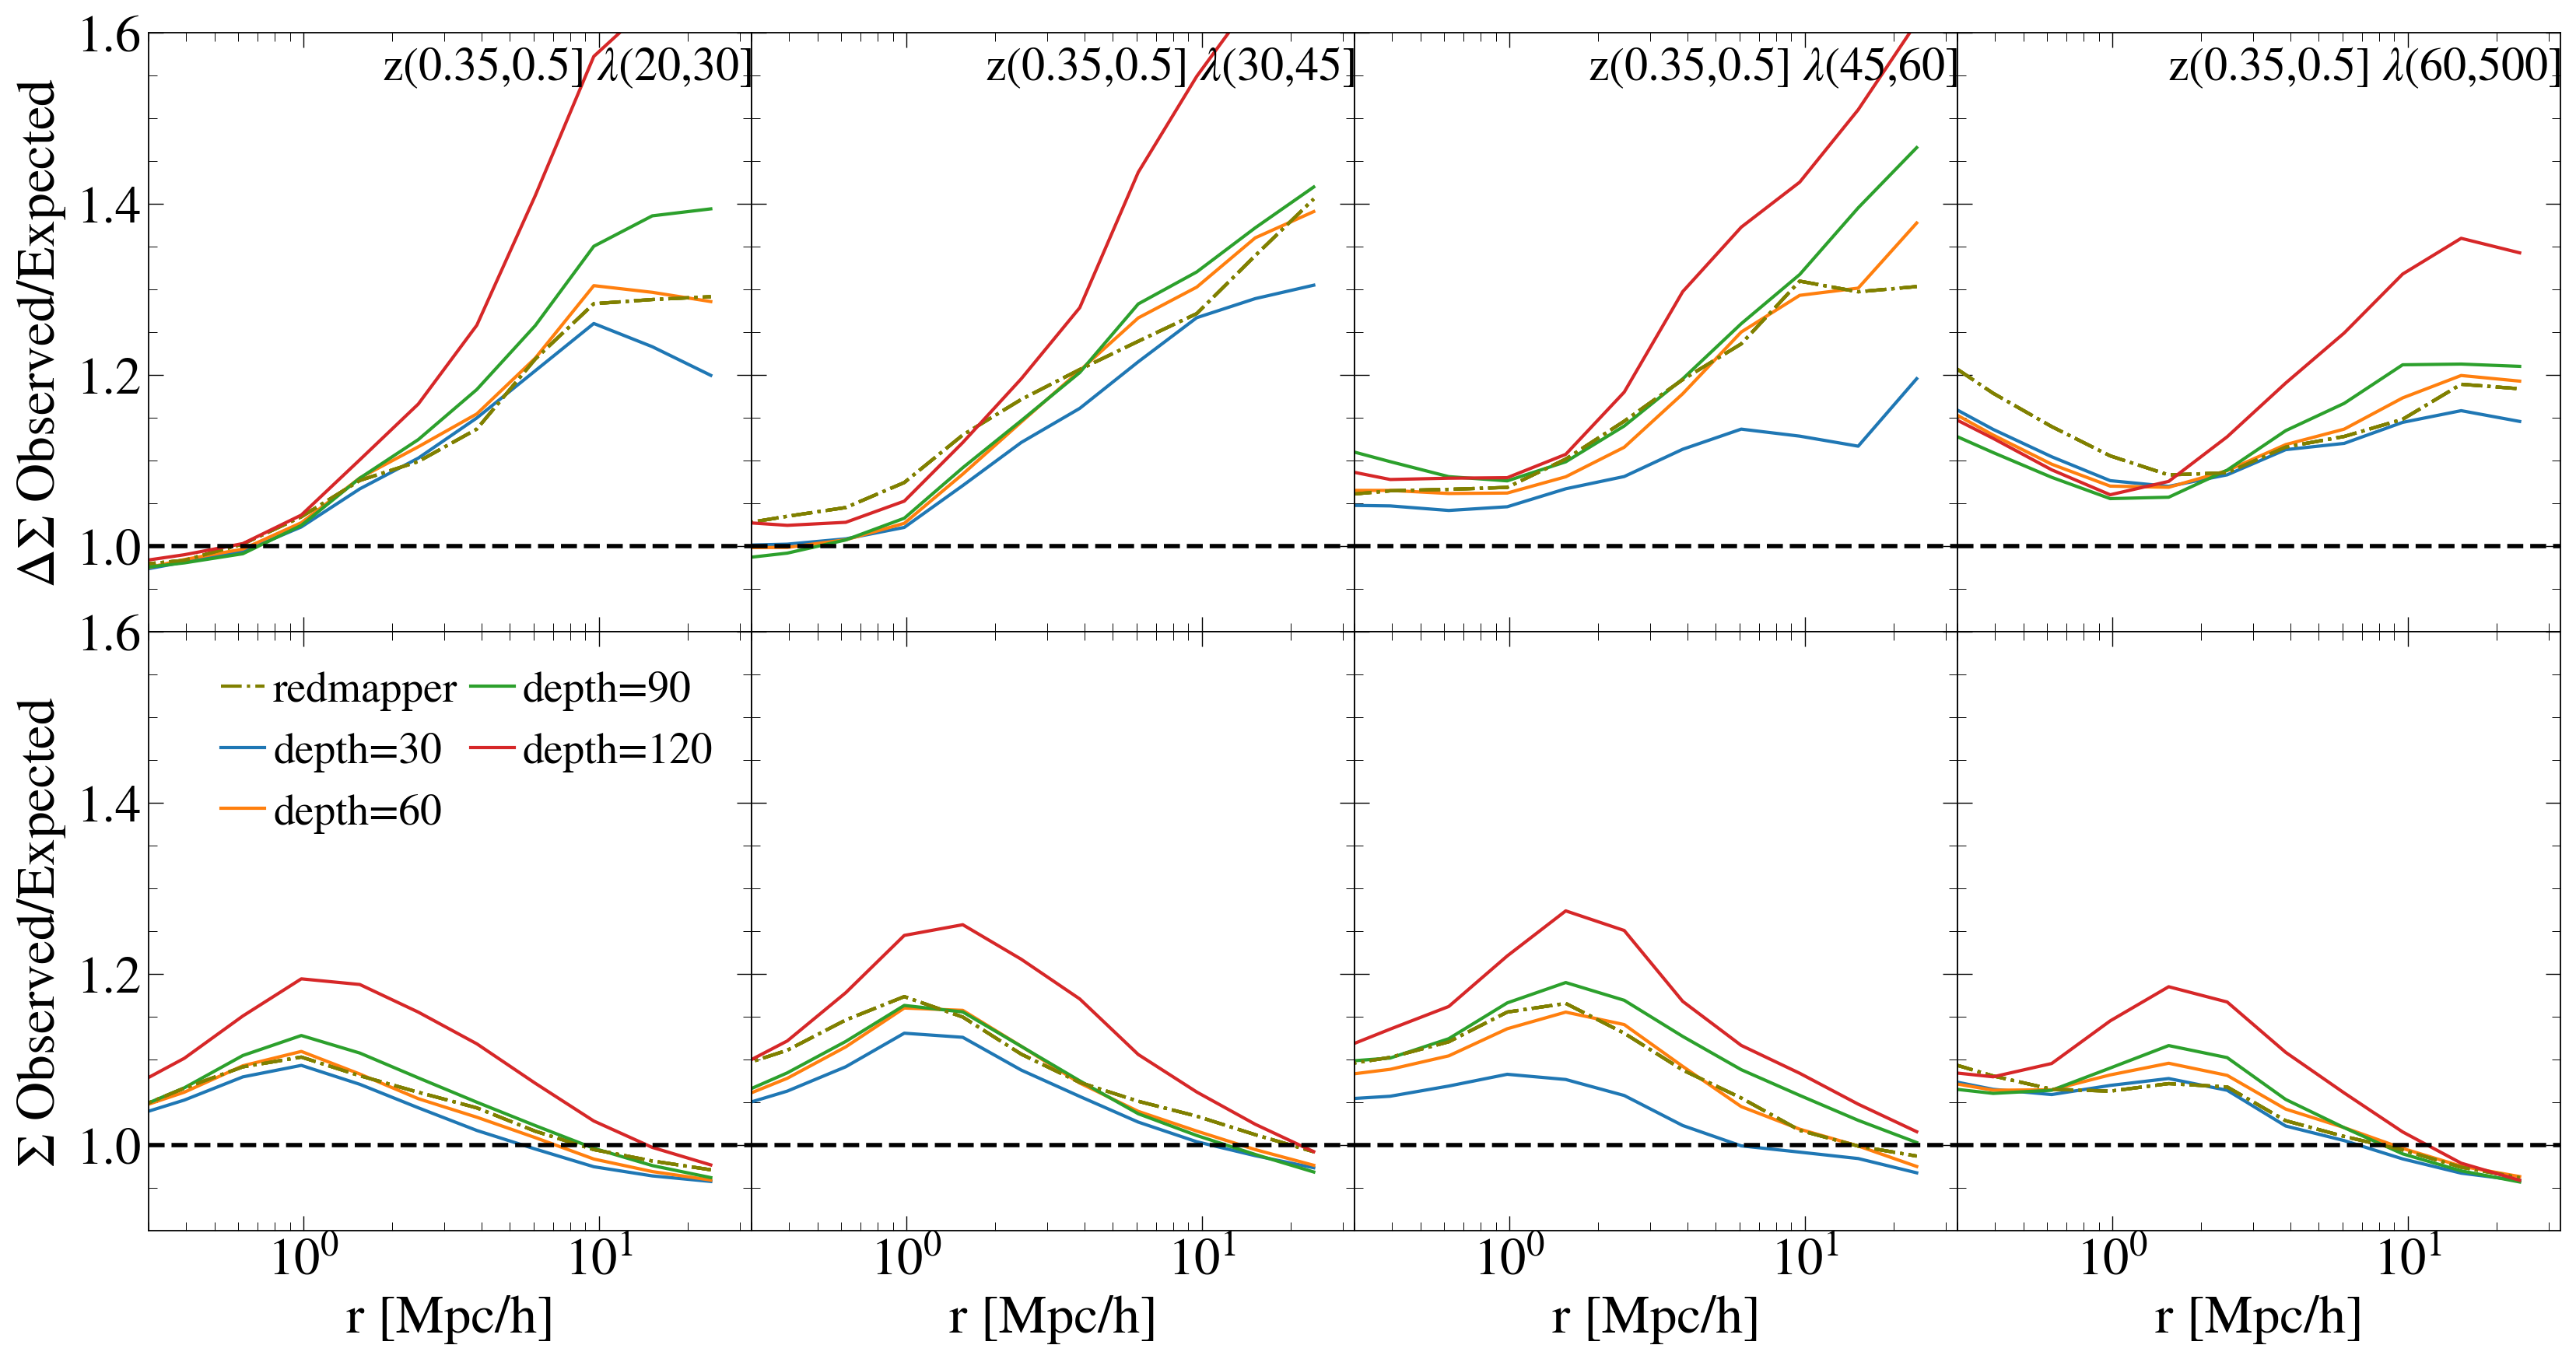

In [9]:
err_rich_sel = np.array([1.36725500e+14, 1.05012334e+14, 7.59645911e+13, 5.18712382e+13,
       3.41863879e+13, 2.19644638e+13, 1.40682675e+13, 9.65293260e+12,
       7.70853661e+12, 6.73140274e+12, 5.93118033e+12, 5.28636874e+12,
       4.80518214e+12, 4.45647268e+12, 4.22414933e+12])

underlying_halos = sigma_ds_profile[(sigma_ds_profile['Redshift'] >= 0.35) & (sigma_ds_profile['Redshift'] < 0.5)]
lnM_All = np.log10(underlying_halos['Mvir'])
z_All = underlying_halos['Redshift']
profile_All = underlying_halos['Sigma']
profile_All_ds = underlying_halos['DeltaSigma']

# Function to select clusters based on lambda values and calculate ratios
def select_and_calculate_ratios(cluster_halo, num_clusters_in_bin, lnM_All, z_All, profile_All_ds, profile_All):
    sorted_indices = np.argsort(np.array(cluster_halo['lam']))[::-1]
    sel_clusters = cluster_halo[sorted_indices[:num_clusters_in_bin]]
    cluster_halo.remove_rows(sorted_indices[:num_clusters_in_bin])
    
    lnM_sel = np.log10(sel_clusters['mass'])
    z_sel = sel_clusters['redshift']
    profile_sel = sel_clusters['Sigma']
    profile_sel_ds = sel_clusters['DeltaSigma']
    
    expected_ds = stacked_profile_weighted_by_mass_redshift(lnM_sel, z_sel, profile_sel_ds, lnM_All, z_All, profile_All_ds)[0]
    expected_sigma = stacked_profile_weighted_by_mass_redshift(lnM_sel, z_sel, profile_sel, lnM_All, z_All, profile_All)[0]
    
    ratio_ds = np.array(profile_sel_ds.mean(axis=0)) / np.array(expected_ds)
    ratio_sigma = np.array(profile_sel.mean(axis=0)) / np.array(expected_sigma)
    
    return ratio_ds, ratio_sigma


# Create a figure with subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
D = [30, 60, 90, 120, 150,180,210]
for lambda_group in reversed(grouped_cl_halos_red.groups):
#     print(len(lambda_group))
    lnM_sel_red = np.log10(lambda_group['Mvir'])
    z_sel_red = lambda_group['z']
    profile_sel_red = lambda_group['Sigma']
    profile_sel_ds_red = lambda_group['DeltaSigma']
    
    num_clusters_in_bin = len(lambda_group)
    
    expected_ds_red, err_expected_ds_red = stacked_profile_weighted_by_mass_redshift(lnM_sel_red, z_sel_red, profile_sel_ds_red, lnM_All, z_All, profile_All_ds)
    expected_sigma_red, err_expected_sigma_red = stacked_profile_weighted_by_mass_redshift(lnM_sel_red, z_sel_red, profile_sel_red, lnM_All, z_All, profile_All)

    ratio_ds_red = np.array(profile_sel_ds_red.mean(axis=0)) / np.array(expected_ds_red)
    ratio_sigma_red = np.array(profile_sel_red.mean(axis=0)) / np.array(expected_sigma_red)

    
    # Iterate over different cluster_halo datasets
    for i, cluster_halo in enumerate([cluster_halo_30, cluster_halo_60, cluster_halo_90, cluster_halo_120]): #, cluster_halo_150, cluster_halo_180, cluster_halo_210
        ratio_ds, ratio_sigma = select_and_calculate_ratios(cluster_halo, num_clusters_in_bin, lnM_All, z_All, profile_All_ds, profile_All)

        # Plotting
        lambda_value = float(re.findall(r'\d+', lambda_group['lambda_range'][0])[0])
        col_index = int(lambda_value) // 15 - 1
        
        axes[0, col_index].plot(bins, ratio_ds_red, linestyle='dashdot', color='olive')
        axes[0, col_index].plot(bins, ratio_ds)
        axes[0, col_index].grid(visible=False)
#         axes[0, col_index].set_ylim([0.5, 2])
        
        axes[1, col_index].plot(bins, ratio_sigma_red, linestyle='dashdot', color='olive',label='redmapper' if i == 0 else None)
        axes[1, col_index].plot(bins, ratio_sigma,label=f'depth={D[i]}' )
        axes[1, col_index].set_ylim([0.9, 1.6])
        axes[1, col_index].grid(visible=False)
                                    
    # Set plot properties
    for row_index, ax_row in enumerate(axes):
        ax_row[col_index].set_xscale('log')
        ax_row[col_index].set_ylabel('$\Delta\Sigma$ Observed/Expected' if row_index == 0 else '$\Sigma$ Observed/Expected', fontsize=25)
        ax_row[0].legend(loc='best', frameon=False, ncol=2, fontsize=20,
                        handletextpad=0.2, 
                        columnspacing=0.3,
                        markerscale=0.8,  # Scale down the size of the markers
                        handlelength=1 )

    title = f'z(0.35,0.5] $\lambda${lambda_group["lambda_range"][0]}'
    title_y = 1.1 if row_index > 3 else 0.9
    axes[0, col_index].set_title(title, loc='right', y=title_y)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0, wspace=0)

for ax in axes.flat:
    ax.label_outer()
    ax.tick_params(axis='both', labelsize=24)
    ax.axhline(y=1, color='black', linestyle='--', linewidth=2)

# Set the x and y-axis labels for the bottom subplots
for ax in axes[-1, :]:
    ax.set_xlabel('r [Mpc/h]', fontsize=25)

for ax in axes[1, :]:
    ax.set_xlim(0.3, None)
filep = r'/bsuhome/gladyskamau/BSU-Research/Cardinal/'
plt.savefig(filep + 'Images/cardinal_depth_bias.png', facecolor='white')
plt.show()


# Troubleshoot the depths selection bias
## 1

# Load redMaPPer catalog

In [3]:
# redmapper_file = FITS(filepath+"redmapper_v4_v8_v51_y6_v7/run/Cardinal-3Y6a_v2.0_run_run_redmapper_v0.8.1_lgt20_vl02_catalog.fit", mode=0)
# redmapper = Table(redmapper_file[1].read())
# print(len(redmapper))
# redmapper_filtd_un = redmapper[(redmapper['z']>=0.35) & (redmapper['z']<0.5)]
# redmapper_filtd = Table(np.sort(redmapper[(redmapper['z']>=0.35) & (redmapper['z']<0.5)], order='lambda')[::-1])
# print(len(redmapper_filtd))
# redmapper_filtd[:5]

In [24]:
print(sum(cluster_30['lam']>20),sum(cluster_60['lam']>20),sum(cluster_90['lam']>20),sum(cluster_120['lam']>20))
print(len(cluster_30['lam']),len(cluster_60['lam']),len(cluster_90['lam']),len(cluster_120['lam']))
print(len(np.unique(cluster_30['pixelid'])),len(np.unique(cluster_60['pixelid'])),len(np.unique(cluster_90['pixelid'])),len(np.unique(cluster_120['pixelid'])))

1706 1716 1617 2016
189977 164974 144108 162166
1565 1362 1213 1347


In [30]:
thirty = cluster_30['lam'][np.isin(cluster_30['pixelid'], cluster_90['pixelid'])]
sixty = cluster_60['lam'][np.isin(cluster_60['pixelid'], cluster_90['pixelid'])]
onetwenty = cluster_120['lam'][np.isin(cluster_120['pixelid'], cluster_90['pixelid'])]
len(thirty), len(sixty), len(onetwenty)

(139324, 122675, 110885)

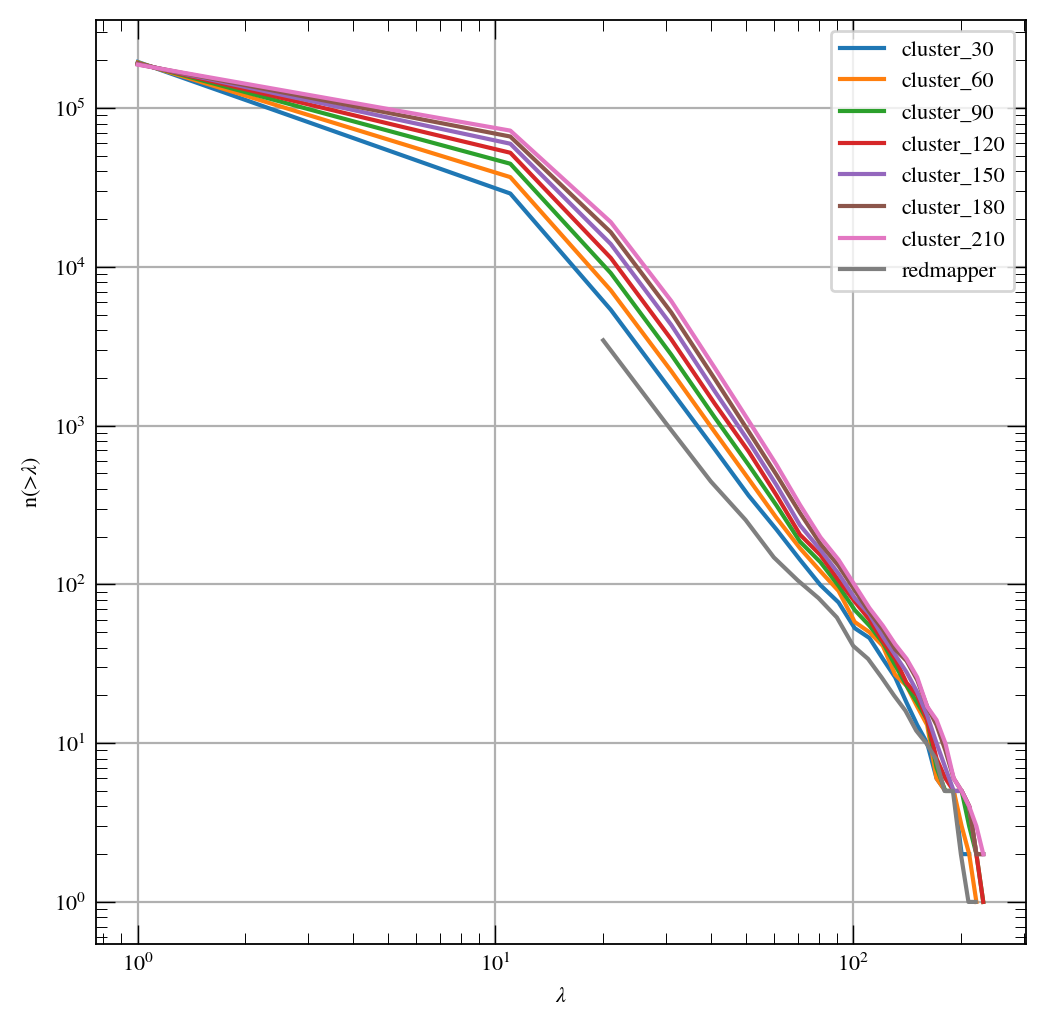

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def n_greater_than_lambda(data):
    for i in range(len(data)):
        lambda_values = np.arange(data[i].min(), data[i].max(), 10)
#         print(lambda_values)
        n_greater_than_lambda = np.zeros(lambda_values.shape)
        for j in range(len(lambda_values)):
            n_greater_than_lambda[j] = np.count_nonzero(data[i] > lambda_values[j]) #/ len(data[i])
#         print(n_greater_than_lambda)
        plt.yscale('log')
        plt.xscale('log')
        plt.plot(lambda_values, n_greater_than_lambda, label=labels[i])

    plt.xlabel('$\lambda$')
    plt.ylabel('n(>$\lambda$)')
#     plt.xlim(20,None)
#     plt.ylim(None,4e3)
    plt.legend()
    plt.show()

# Generate some data
data = [cluster_30['lam'],cluster_60['lam'],cluster_90['lam'],cluster_120['lam'],
        cluster_150['lam'],cluster_180['lam'],cluster_210['lam'],redmapper_filtd_un['lambda']]
labels = ['cluster_30', 'cluster_60', 'cluster_90', 'cluster_120','cluster_150','cluster_180','cluster_210', 'redmapper']

n_greater_than_lambda(data)


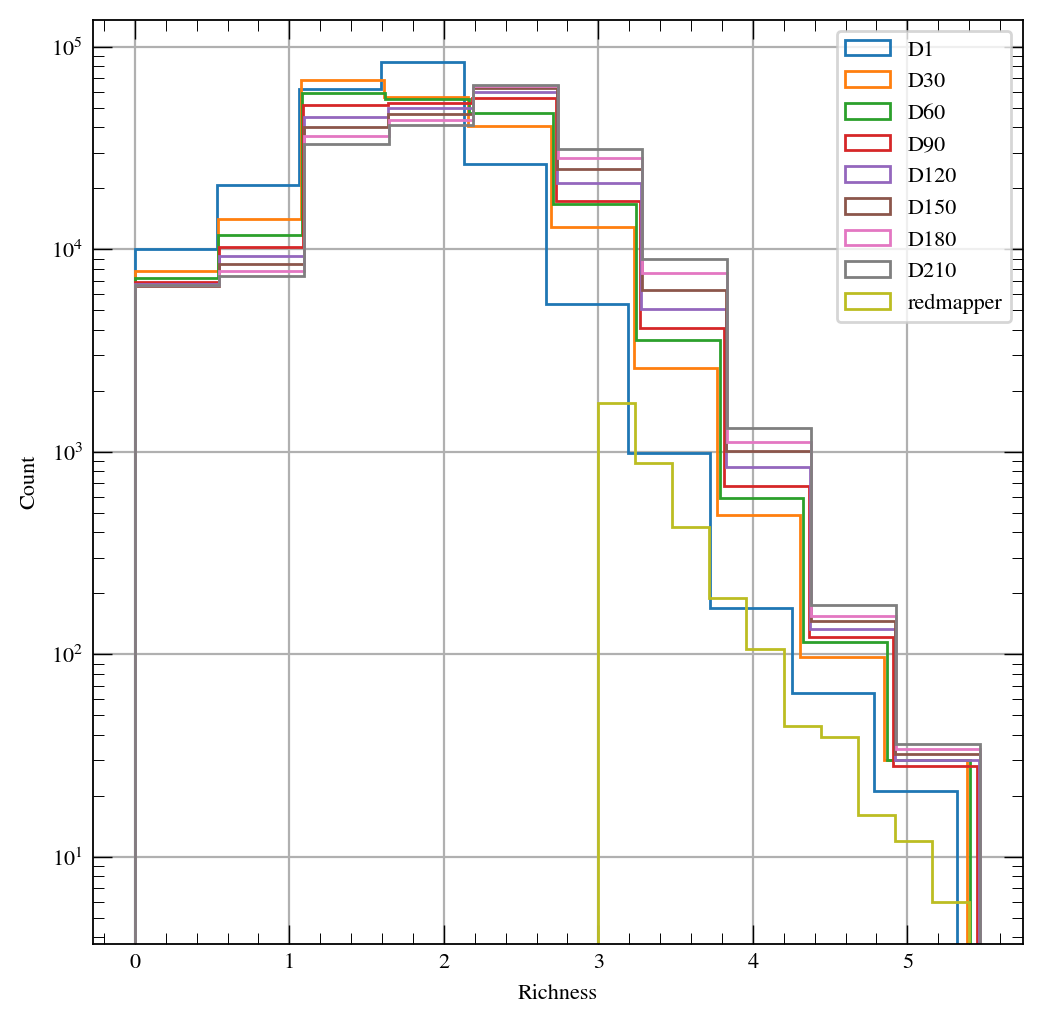

In [15]:
plt.hist(np.log(cluster_1['lam']), label='D1',  histtype='step')
plt.hist(np.log(cluster_30['lam']), label='D30', histtype='step')
plt.hist(np.log(cluster_60['lam']), label='D60', alpha=1, histtype='step')
plt.hist(np.log(cluster_90['lam']), label='D90',  histtype='step')
plt.hist(np.log(cluster_120['lam']), label='D120',  histtype='step')
plt.hist(np.log(cluster_150['lam']), label='D150',  histtype='step')
plt.hist(np.log(cluster_180['lam']), label='D180',  histtype='step')
plt.hist(np.log(cluster_210['lam']), label='D210',  histtype='step')
plt.hist(np.log(redmapper_filtd_un['lambda']), label='redmapper',  histtype='step')

# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Richness')  # Adjusted to put 'lam' on the x-axis
plt.ylabel('Count')
plt.legend()
plt.show()